## Introduction

What do we want to achieve?
We want to build a model that can predict Jack's death and Rose's survival and understand why they died or not.

Steps
- Exploration
    - Get your data
    - Devide into training and test sets
    - Look at your training data: avoid snooping bias
    - Prepare the data for modelling
- Modelling
    - Define an evaluation metric
    - Define a baseline model to beat
    - Try a more complex model
    - Experiment with parameters
- Evaluation
    - Evaluate the model in more detail: are there sections of the data where it doesn't perform well?
- Refinement
    - Can you improve your data?
    - Fine-tune the model if needed
- Understand the model's decisions: do they make sense?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import shap
import os
sns.set_theme(style="darkgrid")

## Exploration

### Get your data

In [2]:
# read datasets
titanic = pd.read_csv('train.csv')

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
titanic.drop(['PassengerId','Name','Ticket','Cabin'],axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,male,NaN,2,0,27.14,S
1,0,3,male,NaN,0,0,13.35,S
2,0,3,male,0.33,1,2,71.29,S
3,0,3,male,19.00,0,0,13.04,S
4,1,3,male,25.00,0,0,7.76,S


In [5]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


### Devide into training and test sets

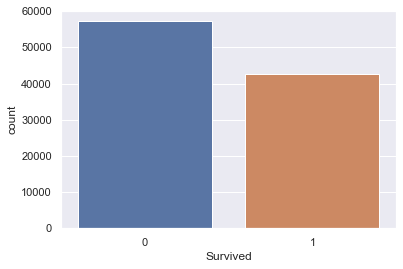

In [6]:
ax = sns.countplot(x="Survived", data=titanic)

In [7]:
# split dataset using StratifiedShuffleSplit to avoid imbalanced train and test sets
titanic_labels = pd.DataFrame(titanic['Survived']).copy()
titanic.drop(['Survived'], axis=1, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(titanic, titanic_labels):
    titanic_train, titanic_test = titanic.loc[train_index], titanic.loc[test_index]
    titanic_labels_train, titanic_labels_test = titanic_labels.loc[train_index], titanic_labels.loc[test_index]
    
print('Training set:\n', titanic_labels_train['Survived'].value_counts()/len(titanic_labels_train['Survived']))
print('Test set:\n', titanic_labels_test['Survived'].value_counts()/len(titanic_labels_test['Survived']))

Training set:
 0    0.572263
1    0.427737
Name: Survived, dtype: float64
Test set:
 0    0.57225
1    0.42775
Name: Survived, dtype: float64


### Look at your training data: avoid snooping bias

#### Data distributions

In [8]:
titanic_train_labelled = titanic_train.copy()
titanic_train_labelled['Survived'] = titanic_labels_train

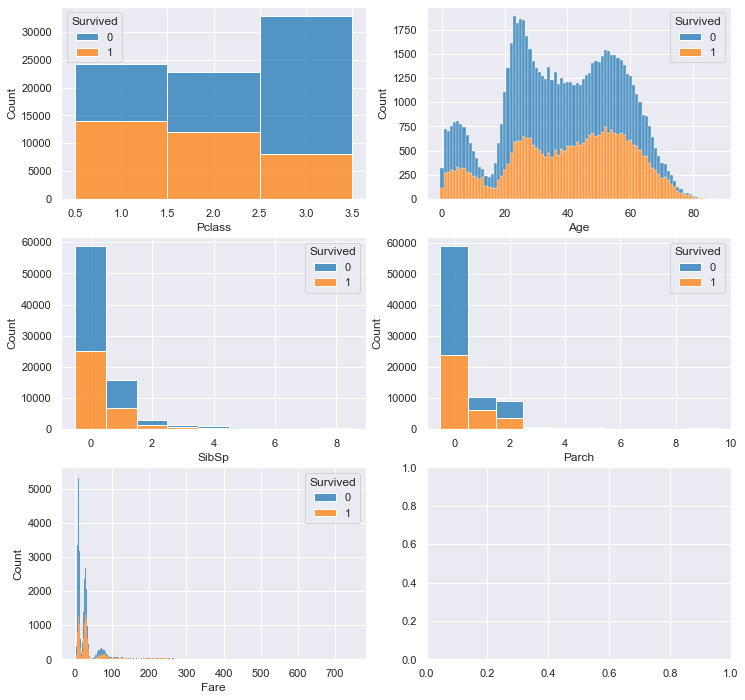

In [9]:
fig, axs = plt.subplots(3,2, figsize=(12,12))
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
nx = axs.shape[0]
ny = axs.shape[1]
for x in range(nx):
    for y in range(ny):
        idx = x*(nx-1) + y
        if idx < (len(features)):
            sns.histplot(data=titanic_train_labelled, 
                         x=features[idx], 
                         hue='Survived', 
                         multiple='stack', 
                         ax=axs[x,y], 
                         discrete=True,
                         palette='tab10'
                        )
plt.show()

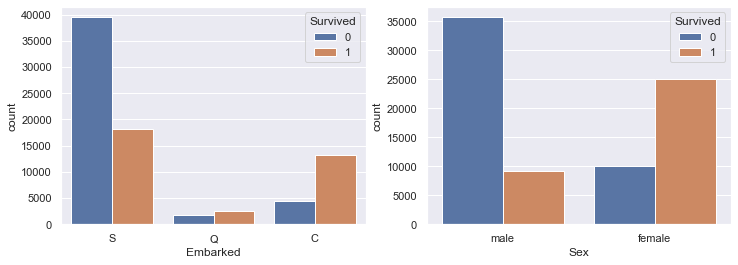

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x="Embarked", data=titanic_train_labelled, hue="Survived", ax=axs[0])
sns.countplot(x="Sex", data=titanic_train_labelled, hue="Survived", ax=axs[1])
plt.show()

#### Correlations

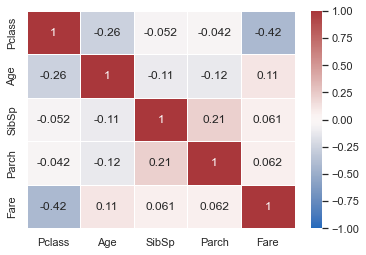

In [11]:
# ignoring the sign
ax = sns.heatmap((titanic_train.corr()), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap="vlag")

#### Missing data

In [12]:
titanic_train.isna().any()

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
Embarked     True
dtype: bool

### Prepare the data for modelling

#### Create transformation pipeline

In [13]:
# create data transformation pipelines for categorical and numerical features separately

num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # impute missing values
    ('std_scaler', StandardScaler()) # normalize data
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # impute missing values
    ('one_hot', OneHotEncoder(drop='if_binary')) # categorical -> numerical
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

#### Prepare the training set

In [14]:
titanic_train_prep = full_pipeline.fit_transform(titanic_train)
titanic_labels_train_prep = titanic_labels_train['Survived'].to_numpy(dtype=int)

In [15]:
# get the final feature names
one_hot_names = full_pipeline.named_transformers_['cat'].steps[1][1].get_feature_names_out(cat_cols)
feature_names = num_cols + list(one_hot_names)

#### Prepare the test set
Let's add Jack and Rose to the test set

In [16]:
# adding jack and rose to the test set so we don't train the model on them
jack = {'Pclass': 3,
        'Sex': 'male',
        'Age': 20,
        'SibSp': 0,
        'Parch': 0,
        'Fare': 7.8,
        'Embarked': 'S'}
jack_pd = pd.DataFrame(data=jack, index=[0])

rose = {'Pclass': 1,
        'Sex': 'female',
        'Age': 17,
        'SibSp': 1, # fiance
        'Parch': 1, # mother
        'Fare': 280,
        'Embarked': 'S'}
rose_pd = pd.DataFrame(data=rose, index=[0])

jack_and_rose = pd.concat([jack_pd, rose_pd], ignore_index=True)
jack_and_rose_labels = pd.DataFrame([0, 1], columns=['Survived'])

titanic_test = pd.concat([titanic_test, jack_and_rose], ignore_index=True)
titanic_labels_test = pd.concat([titanic_labels_test, jack_and_rose_labels], ignore_index=True)

In [17]:
titanic_test.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
19997,3,male,33.0,1,0,8.81,S
19998,1,female,50.0,0,0,18.26,S
19999,3,male,28.0,0,0,12.89,S
20000,3,male,20.0,0,0,7.80,S
20001,1,female,17.0,1,1,280.00,S


In [18]:
titanic_labels_test.tail()

,Survived
19997,0
19998,1
19999,0
20000,0
20001,1


In [19]:
# apply pipeline to test set
titanic_test_prep = full_pipeline.fit_transform(titanic_test)
titanic_labels_test_prep = titanic_labels_test['Survived'].to_numpy(dtype=int)

## Modelling

### Define an evaluation metric
For consistency with Kaggle, we will accuracy, which gives a percentage of correct predictions, to measure model performance. This is not always advisable for classification problems, as it can be misleading, especially in unbalanced datasets. Typically, we would look at precision and recall. Have a look here: https://medium.com/@shrutisaxena0617/precision-vs-recall-386cf9f89488

Kaggle's leaderboard top accuracy stands at 0.81328 - Let's beat it!

### Esblishing a baseline
Training a single decision tree\
TODO: Advantages x disadvantages

In [41]:
tree_clf = DecisionTreeClassifier(
#     max_depth=3,
#     max_leaf_nodes=5, 
    random_state=42
)
tree_clf.fit(titanic_train_prep, titanic_labels_train_prep)
tree_train_preds = tree_clf.predict(titanic_train_prep)
tree_test_preds = tree_clf.predict(titanic_test_prep)

In [42]:
tree_train_acr = accuracy_score(titanic_labels_train_prep, tree_train_preds)
tree_test_acr = accuracy_score(titanic_labels_test_prep, tree_test_preds)
print('Tree accuracy on train {} and test {}:'.format(tree_train_acr, tree_test_acr))

Tree accuracy on train 0.993975 and test 0.6844815518448155:


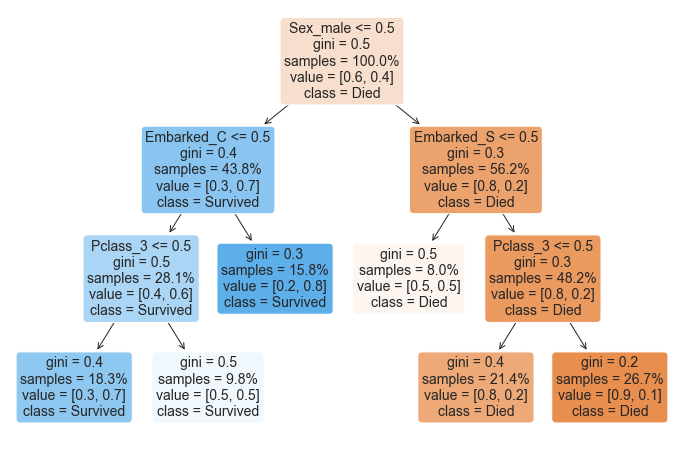

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
tree.plot_tree(tree_clf,
               feature_names=feature_names,
               class_names=['Died', 'Survived'],
               filled=True,
               proportion=True,
               rounded=True,
               precision=1
              )
plt.show()

### Try a more complex model
Bring out the big guns, aka, XGBoost

In [43]:
dtrain = xgb.DMatrix(titanic_train_prep, titanic_labels_train_prep)
dtest = xgb.DMatrix(titanic_test_prep, titanic_labels_test_prep)

In [48]:
params = {"max_depth": 6, # default
          "eta": 0.3, # default
          "objective": "binary:hinge", # for binary classification
          "eval_metric": "error" # 1 - accuracy
         }

In [45]:
def train_eval_model(params, dtrain, dtest, train_labels, test_labels):
    # train
    xgb_clf = xgb.train(params, dtrain)

    # run prediction
    xgb_train_preds = xgb_clf.predict(dtrain)
    xgb_test_preds = xgb_clf.predict(dtest)
    
    # compute accuracy
    xgb_train_acr = accuracy_score(train_labels, xgb_train_preds)
    xgb_test_acr = accuracy_score(test_labels, xgb_test_preds)
    print('XGBoost accuracy on train {} and test {}:'.format(xgb_train_acr, xgb_test_acr))
    
    return xgb_clf

In [46]:
xgb_clf = train_eval_model(params, dtrain, dtest, titanic_labels_train_prep, titanic_labels_test_prep)

XGBoost accuracy on train 0.7682125 and test 0.7658734126587341:


### Experiment with parameters

In [47]:
params["max_depth"] = 20
xgb_clf_mf = train_eval_model(params, dtrain, dtest, titanic_labels_train_prep, titanic_labels_test_prep)

XGBoost accuracy on train 0.944125 and test 0.7241275872412759:


The model is overfitting!

In [49]:
params["eta"] = 0.1
xgb_clf_eta = train_eval_model(params, dtrain, dtest, titanic_labels_train_prep, titanic_labels_test_prep)

XGBoost accuracy on train 0.691625 and test 0.6908809119088091:


In [199]:
res = xgb.cv(params, dtrain, num_boost_round=10, nfold=5,
             metrics={'error'}, seed=0, as_pandas=True)
res.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.306188,0.000816,0.307925,0.004872
1,0.235941,0.000522,0.238475,0.002183
2,0.231913,0.001312,0.234750,0.001688
3,0.230663,0.001358,0.234037,0.001801
4,0.231913,0.001611,0.235687,0.001248


In [ ]:
# tuned_clf = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=splits, return_train_score=True)
# tuned_clf.fit(data, labels, groups=groups)

# print(tuned_clf.best_params_)
# # evaluate best estimator
# scores = cross_validate(tuned_clf.best_estimator_, data, labels, scoring=scoring, cv=splits, groups=groups,
#                         return_train_score=True)

# print(scores["train_score"], scores["test_score"])
# print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

### Refinement
- Can you improve your data?
- Fine-tune the model if needed

## Understand the model's decisions: do they make sense?
We will SHAP for this task, as it is more robust and accurate than tree-based feature importances.\
An interesting article about it: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

Let's look at the training set first

In [26]:
features_pd = pd.DataFrame(titanic_train_prep, columns=[feature_names])
features_pd.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-1.079183,-0.459449,-0.478126,-0.500476,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.645444,-0.459449,0.574145,-0.299418,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.979242,-0.459449,-0.478126,-0.411646,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.479941,-0.459449,-0.478126,-0.276307,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.034876,-0.459449,-0.478126,-0.526475,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [27]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(features_pd)

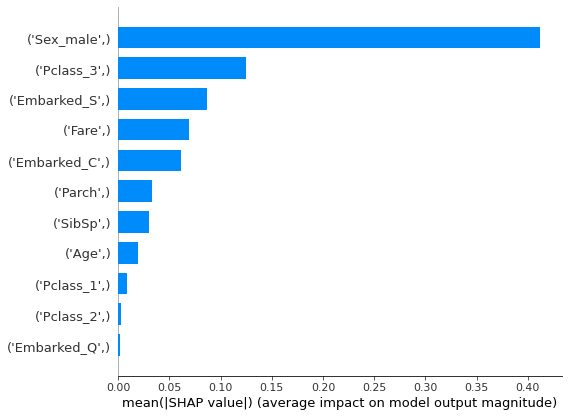

In [28]:
shap.summary_plot(shap_values, features_pd, plot_type='bar')

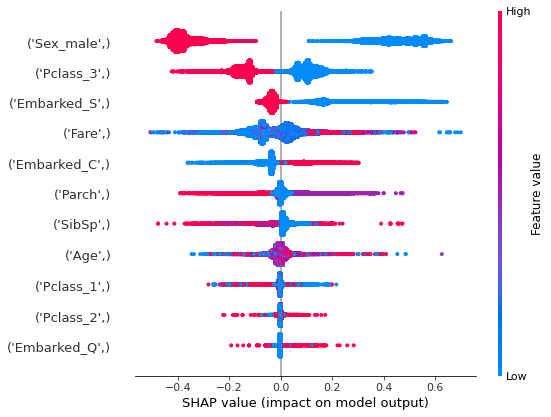

In [29]:
shap.summary_plot(shap_values, features_pd)

**What does the plot show?**
- Positive SHAP value means positive impact on prediction, leading the model to predict 1(e.g. Passenger survived the Titanic). Negative SHAP value means negative impact, leading the model to predict 0 (e.g. passenger didn’t survive the Titanic).
- In this chart, the x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. We can get the general sense of features’ directionality impact based on the distribution of the red and blue dots.

**What can we conclude?**
- Higher value of “Sex_male" (male) leads to lower chance of survive
- Higher value of “Pclass_3” (being on 3rd class) leads to lower chance to survive as well
- Higher value of "Parch" (having more parents/children) leads to mixed results but for some passangers means a lower chance of survival
- Lower value of "Embarked_S" (did not embarked in Southampton) leads to higher change of survival
- Lower value of “Fare” leads to lower chance to survive
- etc...

In [30]:
shap.initjs()

In [31]:
shap.force_plot(explainer.expected_value, shap_values[0,:], features_pd.iloc[0,:], link="logit")

- sex = male has a negative (blue) impact on survival
- parch has a positive (red) impact on survival

In [32]:
shap.force_plot(explainer.expected_value, shap_values[1000,:], features_pd.iloc[1000,:], link="logit")

- sex = female has a positive (red) impact on survival
- no being on the third class has a positive impact on survival
- not having embarked in Cherbourg has a negative impact on survival

Now to the test set

In [33]:
features_test_pd = pd.DataFrame(titanic_test_prep, columns=[feature_names])
shap_values_test = explainer.shap_values(features_test_pd)

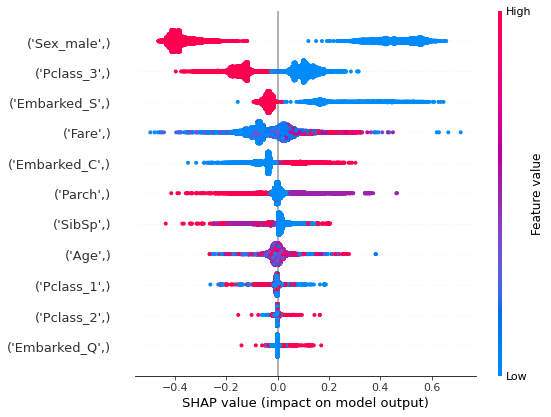

In [34]:
shap.summary_plot(shap_values_test, features_test_pd)

In [35]:
# jack
jack_id = len(shap_values_test)-2

In [36]:
shap.force_plot(explainer.expected_value, shap_values_test[jack_id,:], features_test_pd.iloc[jack_id,:], link="logit")

- Being male: -
- Low shap for parch: + ?

In [37]:
# rose
rose_id = len(shap_values_test)-1

In [38]:
shap.force_plot(explainer.expected_value, shap_values_test[rose_id,:], features_test_pd.iloc[rose_id,:], link="logit")

- Being female: +
- High fare: +
- Not on third class: +